In [14]:
%load_ext autoreload
%autoreload 2
import timeit
import pickle
import numpy as np
import matplotlib.pyplot as plt
from shape import Shape, Block, plot_hulls
from convex_hulls_graph import HullGraph
from shapely.geometry import Point, Polygon
from shapely.affinity import rotate
import shapely.ops as ops
from shape_boat import ShapeBoat, ShapeBoat_spline, check_vertex_constraints
%autoreload 2
from shapeshift_trajectory import shapeshift_trajectory, write_experiment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Composing Shapes from Blocks

In [2]:
shape_1a = Shape([Block(0,0)])
shape_2a = Shape([Block(-.5,0),   Block(.5,0)])
shape_2b = Shape([Block(0,0.25),  Block(0,-0.25)])
shape_3a = Shape([Block(-.5,0),   Block(.5,0),   Block(-1.25,0.25,90)])
shape_3b = Shape([Block(-.5,0),   Block(.5,0,0), Block(-.5,0.5)])
shape_3c = Shape([Block(0,0),     Block(-1,0),   Block(1,0)])
shape_4a = Shape([Block(-.5,0),   Block(.5,0),   Block(-1.25,0.25,90),Block(1.25,0.25,90)])
shape_4b = Shape([Block(-.5,-.25),Block(-.5,.25),Block(.5,-.25),      Block(.5,.25)])
shape_6a = Shape([Block(0,0),     Block(1.,0),   Block(0,0.5),        Block(-1.,0.5),Block(1.,0.5),Block(1.,-.5)])

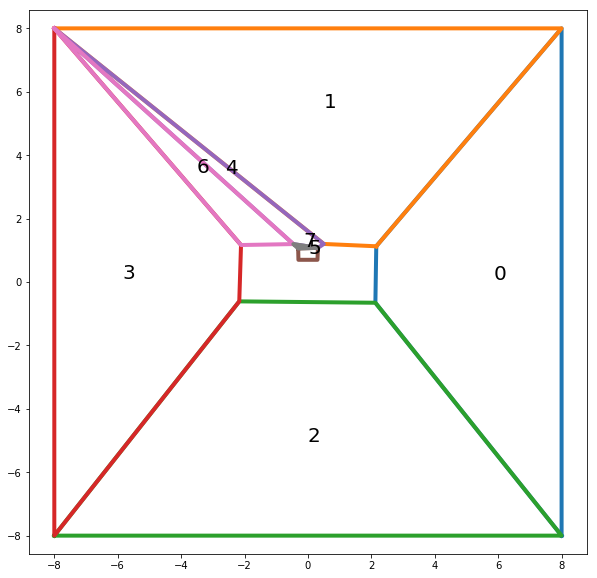

finding_vertex POINT (-5 0) 0.0
finding_vertex POINT (5 0) 0.0
found path endpoint hulls 13 8
INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 215
0.001972 seconds
ADDING COSTS
Number of costs 1
0.000751 seconds
ADDING CONSTRAINTS
Number of constraints 638
0.071784 seconds
PLANNING
SolutionResult.kSolutionFound
0.099324 seconds

INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.002752 seconds
ADDING COSTS
Number of costs 1
0.000896 seconds
ADDING CONSTRAINTS
Number of constraints 180
0.010471 seconds
PLANNING
SolutionResult.kSolutionFound
0.001115 seconds

False


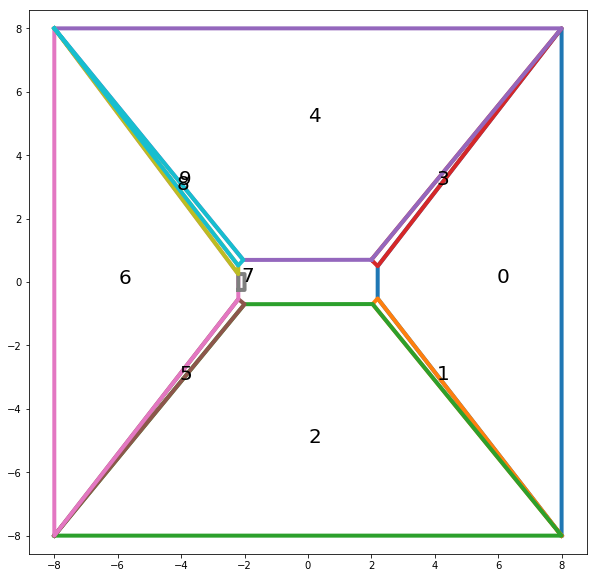

finding_vertex POINT (-2 0) 0.0
finding_vertex POINT (-1.25 0.75) 90.0
found path endpoint hulls 36 5
INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 245
0.007636 seconds
ADDING COSTS
Number of costs 1
0.001096 seconds
ADDING CONSTRAINTS
Number of constraints 1022
0.135867 seconds
PLANNING
SolutionResult.kSolutionFound
0.487509 seconds

INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.002326 seconds
ADDING COSTS
Number of costs 1
0.000822 seconds
ADDING CONSTRAINTS
Number of constraints 180
0.012712 seconds
PLANNING
SolutionResult.kSolutionFound
0.001585 seconds

False


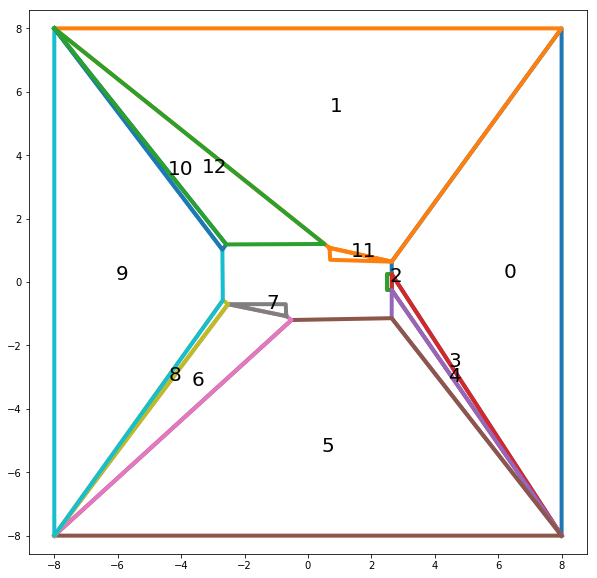

finding_vertex POINT (2.5 0) 0.0
finding_vertex POINT (0 0.5) 180.0
found path endpoint hulls 38 31
INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 275
0.008560 seconds
ADDING COSTS
Number of costs 1
0.000872 seconds
ADDING CONSTRAINTS
Number of constraints 1256
0.141277 seconds
PLANNING
SolutionResult.kSolutionFound
0.742297 seconds

INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.002376 seconds
ADDING COSTS
Number of costs 1
0.000828 seconds
ADDING CONSTRAINTS
Number of constraints 180
0.015146 seconds
PLANNING
SolutionResult.kSolutionFound
0.002196 seconds

False


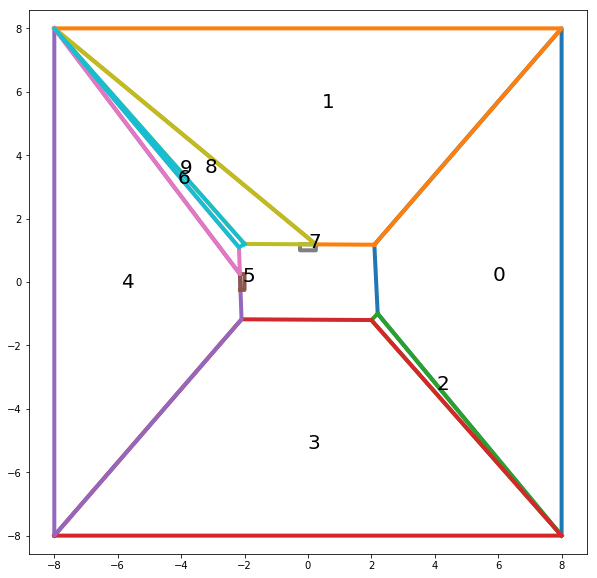

finding_vertex POINT (-2 0) 0.0
finding_vertex POINT (0 1) 0.0
found path endpoint hulls 28 30
INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 245
0.003453 seconds
ADDING COSTS
Number of costs 1
0.001075 seconds
ADDING CONSTRAINTS
Number of constraints 992
0.082308 seconds
PLANNING
SolutionResult.kSolutionFound
0.534962 seconds

INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.003035 seconds
ADDING COSTS
Number of costs 1
0.000846 seconds
ADDING CONSTRAINTS
Number of constraints 180
0.021081 seconds
PLANNING
SolutionResult.kSolutionFound
0.002042 seconds

False


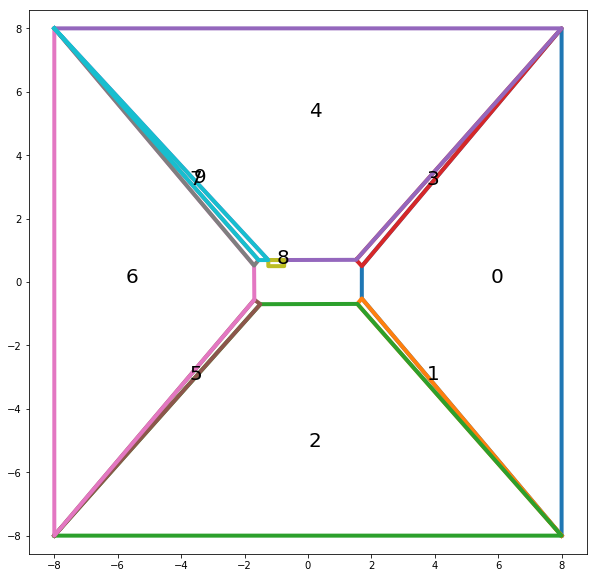

finding_vertex POINT (-2.5 0) 0.0
finding_vertex POINT (-1 0.5) 0.0
found path endpoint hulls 12 30
INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 230
0.002256 seconds
ADDING COSTS
Number of costs 1
0.000709 seconds
ADDING CONSTRAINTS
Number of constraints 800
0.077002 seconds
PLANNING
SolutionResult.kSolutionFound
0.254486 seconds

INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.002324 seconds
ADDING COSTS
Number of costs 1
0.001012 seconds
ADDING CONSTRAINTS
Number of constraints 180
0.010529 seconds
PLANNING
SolutionResult.kSolutionFound
0.001114 seconds

False


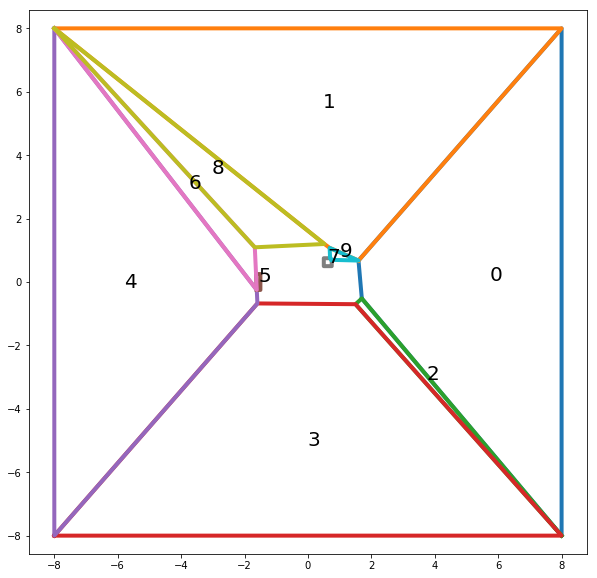

finding_vertex POINT (-1.5 0) 0.0
finding_vertex POINT (0.5 0.5) 0.0
found path endpoint hulls 29 31
INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 260
0.005124 seconds
ADDING COSTS
Number of costs 1
0.000930 seconds
ADDING CONSTRAINTS
Number of constraints 1154
0.133190 seconds
PLANNING
SolutionResult.kSolutionFound
0.644924 seconds

INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.002746 seconds
ADDING COSTS
Number of costs 1
0.000848 seconds
ADDING CONSTRAINTS
Number of constraints 180
0.010588 seconds
PLANNING
SolutionResult.kSolutionFound
0.001244 seconds

False


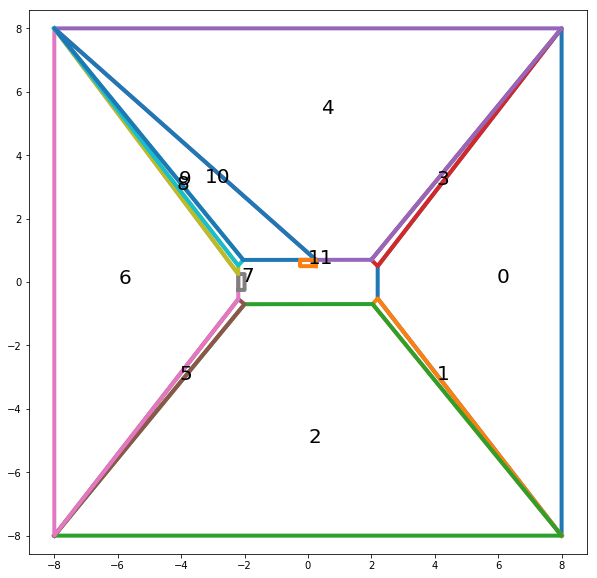

finding_vertex POINT (-2 0) 0.0
finding_vertex POINT (0 0.5) 0.0
found path endpoint hulls 34 38
INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 260
0.003710 seconds
ADDING COSTS
Number of costs 1
0.000837 seconds
ADDING CONSTRAINTS
Number of constraints 1094
0.093850 seconds
PLANNING
SolutionResult.kSolutionFound
0.344412 seconds

INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.002964 seconds
ADDING COSTS
Number of costs 1
0.000976 seconds
ADDING CONSTRAINTS
Number of constraints 180
0.020520 seconds
PLANNING
SolutionResult.kSolutionFound
0.001383 seconds

False


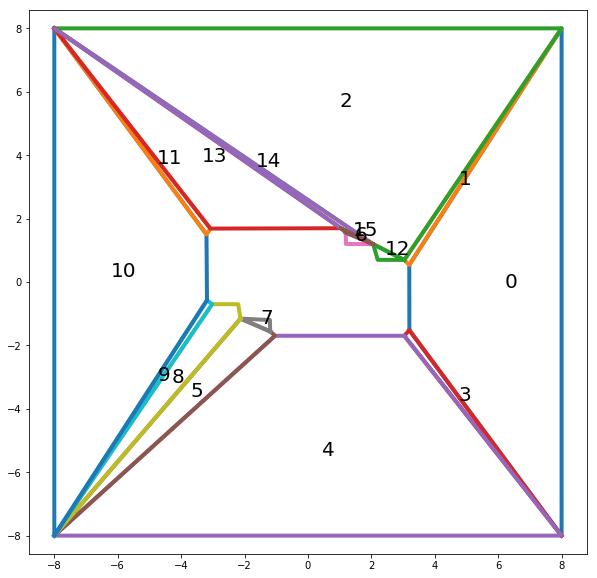

finding_vertex POINT (0 -0.5) 180.0
finding_vertex POINT (0 1.5) 180.0
found path endpoint hulls 31 32
INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 290
0.004861 seconds
ADDING COSTS
Number of costs 1
0.001123 seconds
ADDING CONSTRAINTS
Number of constraints 1508
0.152275 seconds
PLANNING
SolutionResult.kSolutionFound
1.134485 seconds

INITIALIZED ShapeBoat 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.003073 seconds
ADDING COSTS
Number of costs 1
0.002175 seconds
ADDING CONSTRAINTS
Number of constraints 180
0.021171 seconds
PLANNING
SolutionResult.kSolutionFound
0.001388 seconds

False


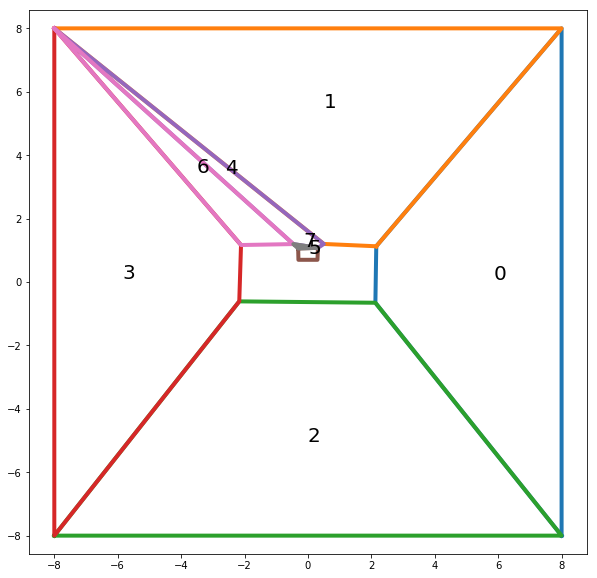

finding_vertex POINT (-5 0) 0.0
finding_vertex POINT (5 0) 0.0
found path endpoint hulls 13 8
INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 215
0.002627 seconds
ADDING COSTS
Number of costs 16
0.008117 seconds
ADDING CONSTRAINTS
Number of constraints 574
0.066294 seconds
PLANNING
SolutionResult.kSolutionFound
0.282455 seconds

INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.003801 seconds
ADDING COSTS
Number of costs 1
0.001332 seconds
ADDING CONSTRAINTS
Number of constraints 60
0.007082 seconds
PLANNING
SolutionResult.kSolutionFound
0.001215 seconds

True


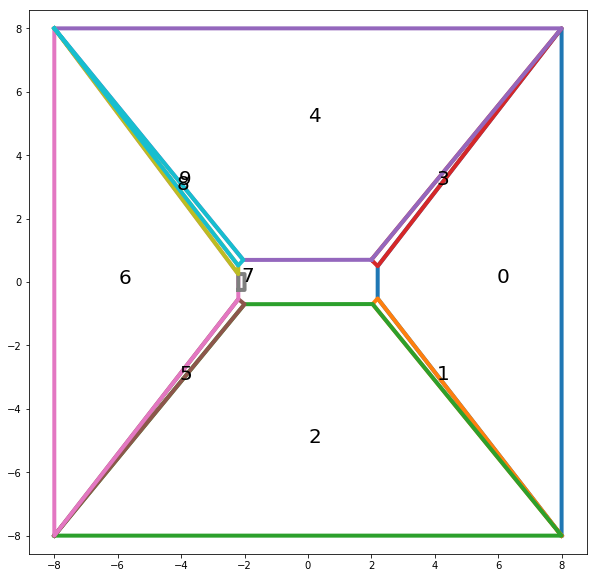

finding_vertex POINT (-2 0) 0.0
finding_vertex POINT (-1.25 0.75) 90.0
found path endpoint hulls 36 5
INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 245
0.002442 seconds
ADDING COSTS
Number of costs 16
0.007613 seconds
ADDING CONSTRAINTS
Number of constraints 958
0.084514 seconds
PLANNING
SolutionResult.kSolutionFound
1.863399 seconds

INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.003171 seconds
ADDING COSTS
Number of costs 1
0.000880 seconds
ADDING CONSTRAINTS
Number of constraints 60
0.005532 seconds
PLANNING
SolutionResult.kSolutionFound
0.001105 seconds

True


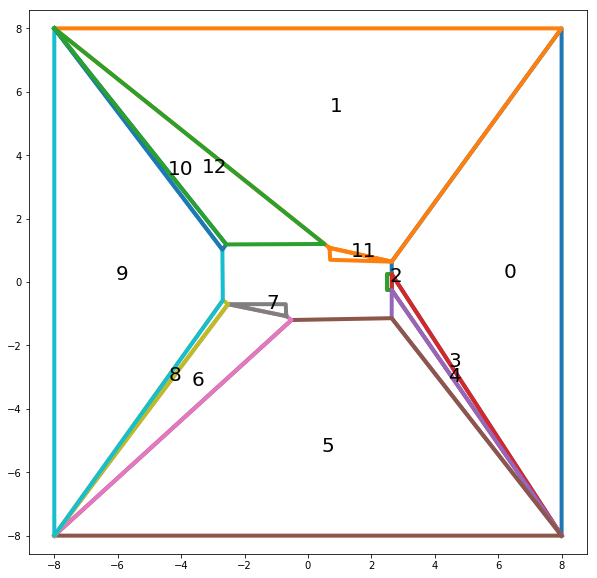

finding_vertex POINT (2.5 0) 0.0
finding_vertex POINT (0 0.5) 180.0
found path endpoint hulls 38 31
INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 275
0.004286 seconds
ADDING COSTS
Number of costs 16
0.007867 seconds
ADDING CONSTRAINTS
Number of constraints 1192
0.136000 seconds
PLANNING
SolutionResult.kSolutionFound
2.040519 seconds

INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.002310 seconds
ADDING COSTS
Number of costs 1
0.000878 seconds
ADDING CONSTRAINTS
Number of constraints 60
0.007680 seconds
PLANNING
SolutionResult.kSolutionFound
0.001522 seconds

True


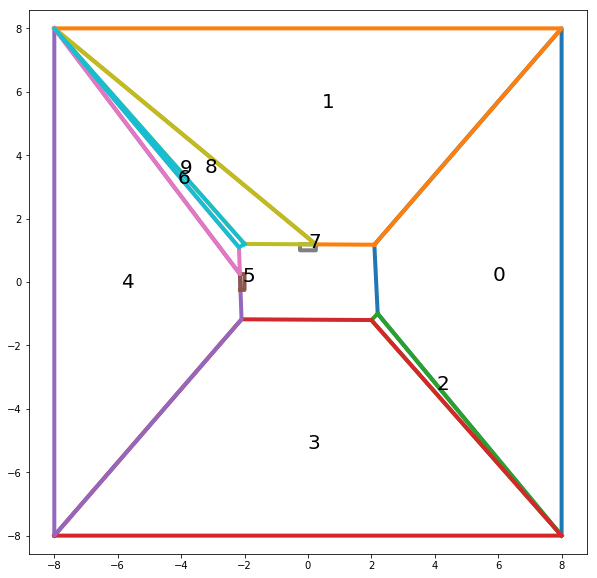

finding_vertex POINT (-2 0) 0.0
finding_vertex POINT (0 1) 0.0
found path endpoint hulls 28 30
INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 245
0.003575 seconds
ADDING COSTS
Number of costs 16
0.008320 seconds
ADDING CONSTRAINTS
Number of constraints 928
0.097025 seconds
PLANNING
SolutionResult.kSolutionFound
2.912076 seconds

INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.002469 seconds
ADDING COSTS
Number of costs 1
0.001248 seconds
ADDING CONSTRAINTS
Number of constraints 60
0.006725 seconds
PLANNING
SolutionResult.kSolutionFound
0.000919 seconds

True


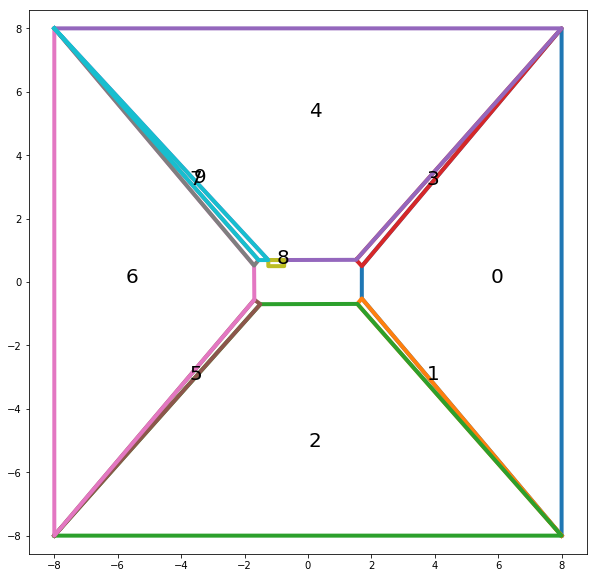

finding_vertex POINT (-2.5 0) 0.0
finding_vertex POINT (-1 0.5) 0.0
found path endpoint hulls 12 30
INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 230
0.003035 seconds
ADDING COSTS
Number of costs 16
0.007916 seconds
ADDING CONSTRAINTS
Number of constraints 736
0.072691 seconds
PLANNING
SolutionResult.kSolutionFound
1.288799 seconds

INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.002927 seconds
ADDING COSTS
Number of costs 1
0.000909 seconds
ADDING CONSTRAINTS
Number of constraints 60
0.004840 seconds
PLANNING
SolutionResult.kSolutionFound
0.000836 seconds

True


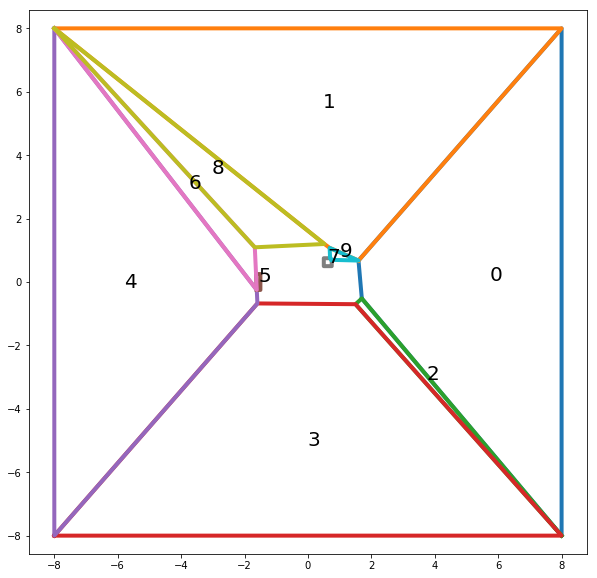

finding_vertex POINT (-1.5 0) 0.0
finding_vertex POINT (0.5 0.5) 0.0
found path endpoint hulls 29 31
INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 260
0.003718 seconds
ADDING COSTS
Number of costs 16
0.008587 seconds
ADDING CONSTRAINTS
Number of constraints 1090
0.138963 seconds
PLANNING
SolutionResult.kSolutionFound
2.646112 seconds

INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.002372 seconds
ADDING COSTS
Number of costs 1
0.000885 seconds
ADDING CONSTRAINTS
Number of constraints 60
0.005604 seconds
PLANNING
SolutionResult.kSolutionFound
0.000883 seconds

True


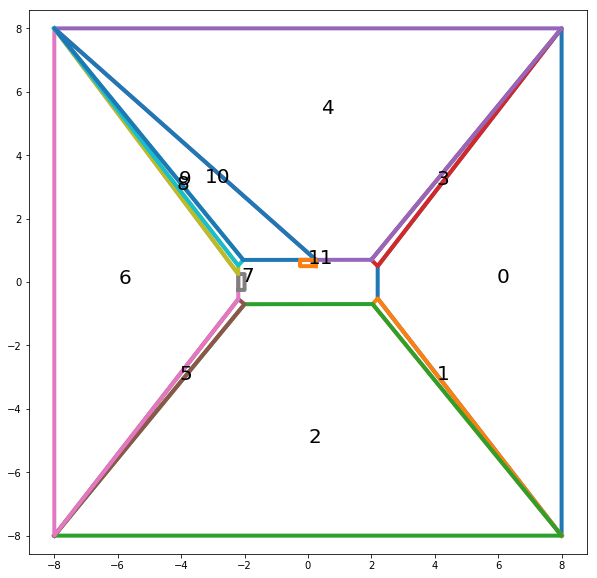

finding_vertex POINT (-2 0) 0.0
finding_vertex POINT (0 0.5) 0.0
found path endpoint hulls 34 38
INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 260
0.002489 seconds
ADDING COSTS
Number of costs 16
0.007036 seconds
ADDING CONSTRAINTS
Number of constraints 1030
0.097980 seconds
PLANNING
SolutionResult.kSolutionFound
1.835951 seconds

INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.002347 seconds
ADDING COSTS
Number of costs 1
0.000835 seconds
ADDING CONSTRAINTS
Number of constraints 60
0.008496 seconds
PLANNING
SolutionResult.kSolutionFound
0.001318 seconds

True


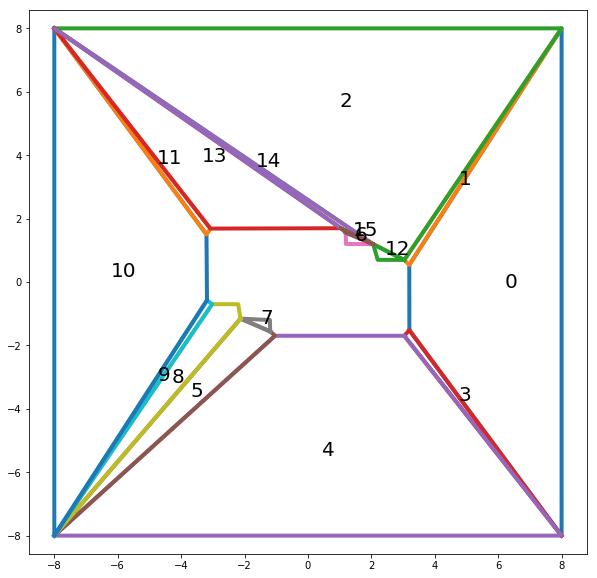

finding_vertex POINT (0 -0.5) 180.0
finding_vertex POINT (0 1.5) 180.0
found path endpoint hulls 31 32
INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 290
0.004892 seconds
ADDING COSTS
Number of costs 16
0.006528 seconds
ADDING CONSTRAINTS
Number of constraints 1444
0.125884 seconds
PLANNING
SolutionResult.kSolutionFound
1.597909 seconds

INITIALIZED ShapeBoat_spline 
boats_S:(1, 16, 6), boats_U:(1, 15, 4)
Number of decision vars 156
0.002366 seconds
ADDING COSTS
Number of costs 1
0.000876 seconds
ADDING CONSTRAINTS
Number of constraints 60
0.007587 seconds
PLANNING
SolutionResult.kSolutionFound
0.001321 seconds

True


In [8]:
tests = {'line_to_L':         (shape_1a, shape_2a, (-2.5, 0.,   0.),    (-1,     .5,   0.)),  \
         'T_to_block':        (shape_1a, shape_3b, (-1.5, 0.,   0.),    (.5,     .5,   0.)),  \
         'line_to_block':     (shape_2a, shape_2a, (-2.,  0.,   0.),    (0.,     .5,   0.)),  \
         'line_to_L2':        (shape_2a, shape_2a, (-2.,  0.,   0.),    (-1.25, .75,  90.)),  \
         'U_to_block':        (shape_3a, shape_3a, (2.5,  0.,   0.),    (0.,     .5, 180.)),  \
         'line_to_block2':    (shape_4b, shape_4b, (-2.,  0.,   0.),    (0.,     1.,   0.)),  \
         'triangle_to_block': (shape_6a, shape_6a, ( 0.,-0.5, 180.),    (0.,    1.5, 180.)),  \
         'past':              (shape_1a, shape_4a, (-5.,  0.,   0.),    (5.,     0.,   0.))   \
        }


boats = {'line':ShapeBoat, 'spline':ShapeBoat_spline}

def result(test,boat):
    try:
        return shapeshift_trajectory(*tests[test],boat_type=boat, N=15)
    except:
        return None

results = {boat:{test: result(test, boats[boat]) for test in tests} for boat in boats}

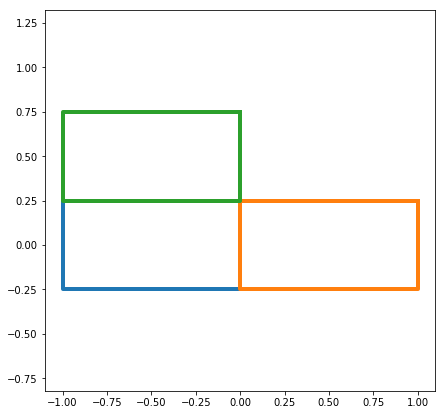

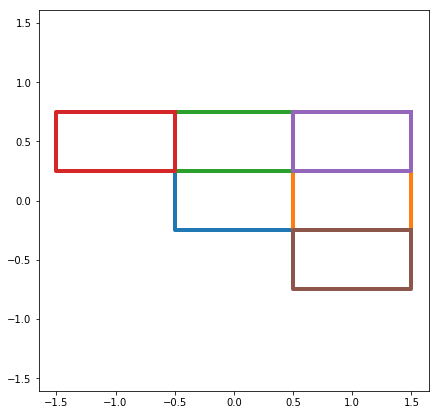

In [9]:
moving_shape=shape_3b
obstacle_shape=shape_6a

moving_shape.plot(union=False)
obstacle_shape.plot(union=False)

### Partitioning of convex hulls around shape

In [10]:
msums, hulls = obstacle_shape.c_space_rotate(moving_shape)
#plot_hulls(hulls, text=False)

### C-Space of a given obstacle b

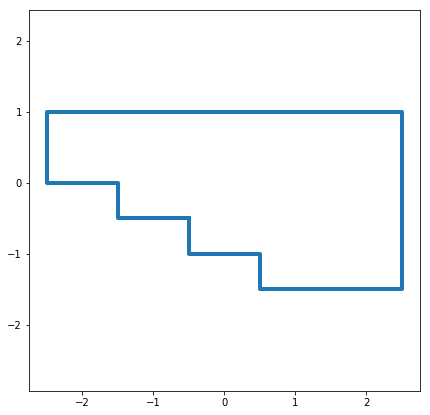

In [11]:
moving_shape.plot_polygons([msums.values()[3]])

### Finding Convex Hull of C-Space

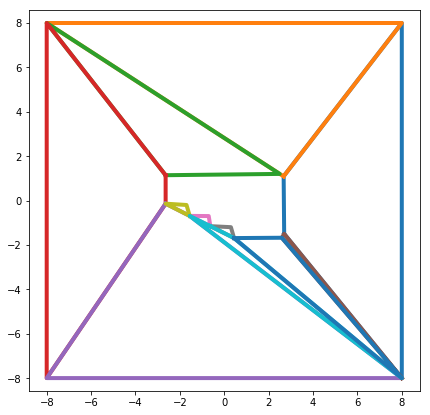

In [12]:
moving_shape.plot_polygons(hulls.values()[3])

## Trajectory Planning

### MIQP - b-splines

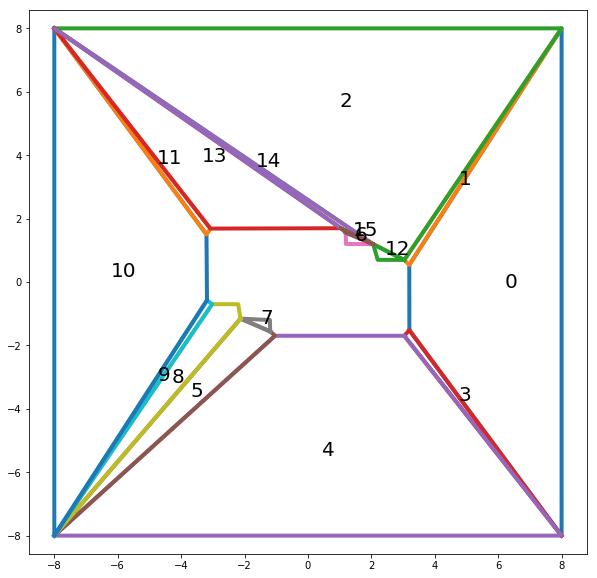

finding_vertex POINT (0 -0.5) 180.0
finding_vertex POINT (0 1.5) 180.0
found path endpoint hulls 31 32
INITIALIZED ShapeBoat 
boats_S:(1, 23, 6), boats_U:(1, 22, 4)
Number of decision vars 423
0.007111 seconds
ADDING COSTS
Number of costs 1
0.001683 seconds
ADDING CONSTRAINTS
Number of constraints 2222
0.170711 seconds
PLANNING
SolutionResult.kSolutionFound
8.267406 seconds

INITIALIZED ShapeBoat 
boats_S:(1, 23, 6), boats_U:(1, 22, 4)
Number of decision vars 226
0.003532 seconds
ADDING COSTS
Number of costs 1
0.002026 seconds
ADDING CONSTRAINTS
Number of constraints 264
0.014791 seconds
PLANNING
SolutionResult.kSolutionFound
0.001870 seconds

False


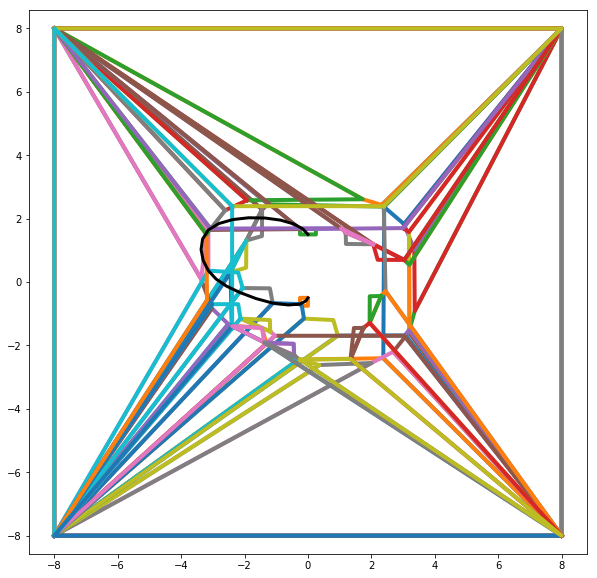

In [7]:
tests = {'line_to_L':         (shape_1a, shape_2a, (-2.5, 0.,   0.),    (-1,     .5,   0.)),  \
         'T_to_block':        (shape_1a, shape_3b, (-1.5, 0.,   0.),    (.5,     .5,   0.)),  \
         'line_to_block':     (shape_2a, shape_2a, (-2.,  0.,   0.),    (0.,     .5,   0.)),  \
         'line_to_L2':        (shape_2a, shape_2a, (-2.,  0.,   0.),    (-1.25, .75,  90.)),  \
         'U_to_block':        (shape_3a, shape_3a, (2.5,  0.,   0.),    (0.,     .5, 180.)),  \
         'line_to_block2':    (shape_4b, shape_4b, (-2.,  0.,   0.),    (0.,     1.,   0.)),  \
         'triangle_to_block': (shape_6a, shape_6a, ( 0.,-0.5, 180.),    (0.,    1.5, 180.)),  \
         'past':              (shape_1a, shape_4a, (-5.,  0.,   0.),    (5.,     0.,   0.))   \
        }

test = 'triangle_to_block'

results = shapeshift_trajectory(*tests[test],boat_type=ShapeBoat, N=22)

if results['success']:
    boats_S = results['S_knots']
    boats_S_new = results['S']
    boat = results['boat']    
    plt.figure(figsize=(10,10))
    plot_hulls([x for a in boat.hulls.values() for x in a], (boats_S_new[0,:,0], boats_S_new[0,:,1]), text=False, figure=False)
    #plt.plot(boats_S_new[0,:,0], boats_S_new[0,:,1], color='red', linewidth='4')
    plt.show()

In [21]:
print results['on_edge']

[0. 0. 0. 0. 0. 0. 0.]


### Show polytope graph from plan

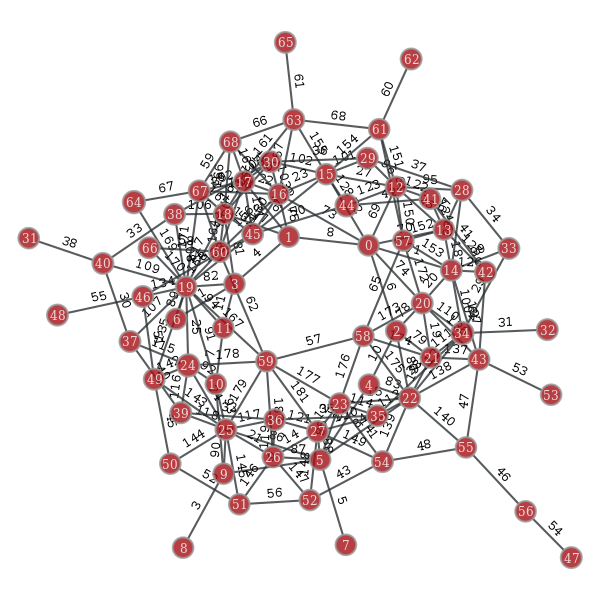

In [19]:
boat.g.draw_graph()

### Show Path with hulls that were used

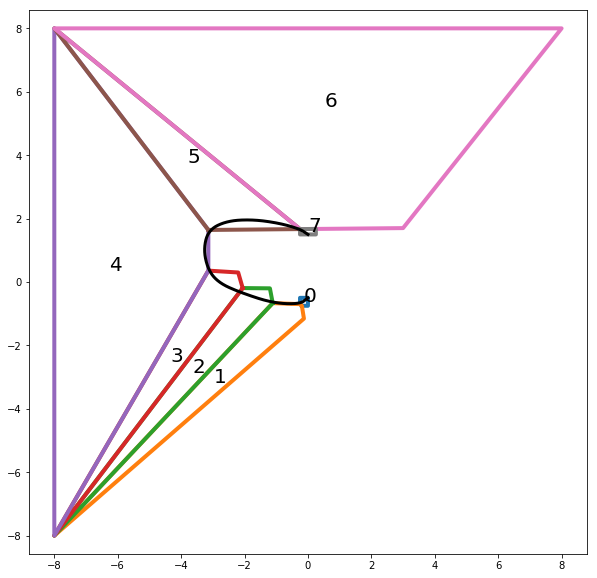

In [12]:
plot_hulls([x['polygon'] for x in boat.hull_path],(boats_S_new[0,:,0], boats_S_new[0,:,1]))